<a href="https://colab.research.google.com/github/monicasjsu/deep_learning/blob/master/PyTorchRESNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import time
from functools import partial
from torchvision import datasets

In [2]:
class Conv2dAuto(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.padding =  (self.kernel_size[0] // 2, self.kernel_size[1] // 2) 
        
conv3x3 = partial(Conv2dAuto, kernel_size=3, bias=False)  
conv = conv3x3(in_channels=32, out_channels=64)
conv2 = nn.Conv2d(16, 32, 3, stride=2, padding=1)
print(conv2)
del conv
Conv2dAuto(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))


Conv2dAuto(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

Data fetch and normalization

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Show some images

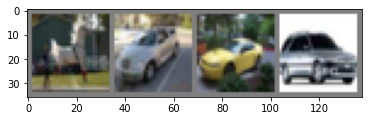

horse   car   car   car


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5    
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

Block in RESNET

In [0]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

RESNET Logic

In [0]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 128

        self.conv1 = nn.Conv2d(3, 128, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(128)
        self.layer1 = self._make_layer(block,  128, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 256, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 512, num_blocks[2], stride=2)
        self.linear1 = nn.Linear(2048, num_classes) #512*exp*block.expansion
        self.linear2 = nn.Linear(2048, num_classes)
        self.emb = nn.Embedding(num_classes, num_classes)
        self.emb.weight = nn.Parameter(torch.eye(num_classes))
    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        #print(out.size())
        #input()
        out1 = self.linear1(out)
        out2 = self.linear2(out.detach())
        # tar = self.emb(targets).cuda()#, torch.index_select(self.emb.weight, 1, targets).cuda())
        return out2
        # return out1, out2, self.emb.weight


def ResNet8():
    return ResNet(BasicBlock, [1,1,1]) #2048

Loss and Optimizer fucntions

In [0]:
import torch.optim as optim

model = ResNet8()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.01)

In [9]:
import torch.cuda
from torchsummary import summary
model = torch.nn.DataParallel(model, device_ids=range(torch.cuda.device_count()))
torch.backends.cudnn.benchmark = True
summary(model.cuda(), (3, 32, 32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 32, 32]           3,456
       BatchNorm2d-2          [-1, 128, 32, 32]             256
            Conv2d-3          [-1, 128, 32, 32]         147,456
       BatchNorm2d-4          [-1, 128, 32, 32]             256
            Conv2d-5          [-1, 128, 32, 32]         147,456
       BatchNorm2d-6          [-1, 128, 32, 32]             256
        BasicBlock-7          [-1, 128, 32, 32]               0
            Conv2d-8          [-1, 256, 16, 16]         294,912
       BatchNorm2d-9          [-1, 256, 16, 16]             512
           Conv2d-10          [-1, 256, 16, 16]         589,824
      BatchNorm2d-11          [-1, 256, 16, 16]             512
           Conv2d-12          [-1, 256, 16, 16]          32,768
      BatchNorm2d-13          [-1, 256, 16, 16]             512
       BasicBlock-14          [-1, 256,

Training the model

In [10]:
from torch.autograd import Variable

def calculate_accuracy(loader):
  total = 0
  correct = 0
  
  with torch.no_grad():
    for data in loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
  return 100 * correct / total 

is_gpu = True
for epoch in range(15):
    running_loss = 0.0
    total_train = 0.0
    correct_train = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        if is_gpu:
            inputs = inputs.cuda()
            labels = labels.cuda()

        inputs, labels = Variable(inputs), Variable(labels)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train +=  labels.nelement()
        correct_train += predicted.eq(labels.data).sum().item()
                                  
    train_accuracy = 100 * correct_train / total_train    
    print('Epoch {}, train Loss: {:.3f}, "accuracy: {:.3f}%'.format(epoch, loss.item(), train_accuracy))

print('==> Finished Training ...')

PATH = './restnet.pth'
torch.save(model.state_dict(), PATH)

Epoch 0, train Loss: 2.340, "accuracy: 34.834%
Epoch 1, train Loss: 1.509, "accuracy: 42.410%
Epoch 2, train Loss: 1.359, "accuracy: 45.044%
Epoch 3, train Loss: 1.462, "accuracy: 46.272%
Epoch 4, train Loss: 1.479, "accuracy: 47.182%
Epoch 5, train Loss: 1.062, "accuracy: 47.890%
Epoch 6, train Loss: 1.875, "accuracy: 48.308%
Epoch 7, train Loss: 0.997, "accuracy: 48.906%
Epoch 8, train Loss: 1.105, "accuracy: 49.010%
Epoch 9, train Loss: 1.002, "accuracy: 49.108%
Epoch 10, train Loss: 1.185, "accuracy: 49.354%
Epoch 11, train Loss: 0.772, "accuracy: 49.754%
Epoch 12, train Loss: 2.272, "accuracy: 49.812%
Epoch 13, train Loss: 0.701, "accuracy: 49.628%
Epoch 14, train Loss: 1.135, "accuracy: 49.580%
==> Finished Training ...


Testing the model


In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        inputs = images.cuda()
        labels = labels.cuda()
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy: {:.3f}%'.format( 100 * correct / total))


cuda:0
Accuracy: 47.640%
